### Natasha-Suchi team.
**For this notebook, most of the code was written by Suchi, a team leader. Natasha wrote the first Kaggle submission as well as participated in the "research," spitting out ideas that sounded reasonable at first but for some reason never worked** 

### Imports

In [17]:
import pandas as pd
import nltk, re, string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier


from sklearn.pipeline import Pipeline

from scipy.sparse import hstack

### Preprocess Data
**The most interesting part here is randomly chosen chunks for a training and a test sets**

In [18]:
# Reads the csv file and load into dataframe and divides it into training and test set
def read_data(run_type):
    df = pd.read_csv("yelp_data_official_training.csv", sep = "|", )
    df = df[df["Review Text"].notnull()]
    if run_type == "train":
        df.apply(np.random.permutation)
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    else:
        df_train = df
        df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", sep="|")
    return df_train, df_test

### Tokenization
**At this step, we tryied different techniques to alter the stopwords. Natasha's idea was to add some dogs and cats into stopwords in order to eliminate some confusion between "Veterinarians" and "Pets" categories, but it didn't work very well. Another idea was to take in only nouns (NN and NNS) to reduce "noise" (i.e. adjectives and other words shared by all reviews). It did not change the accuracy. One more approach was too "innovative": take hypernyms instead of actual tokens and make them tokens. Hypothetis was that on the hyper-level the lexical content of the reviews would be more distinguishable. Turned out, on the hyper-lever it is pretty random-looking.** 

In [19]:
def build_tokens(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens if len(token)>2 and token not in stopwords.words('english') and token not in string.punctuation]
#     tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens if len(token)>2 and token not in string.punctuation]
    tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens


# def build_tokens(text):
#     pattern= r'''(?x) (?:[A-Z]\.)+|(?:\w+(?:[-']\w+)*)|(?:\$?\d+(?:\.\d+)?%?)+|(?:\.\.\.)'''
#     tokens = (nltk.regexp_tokenize(text,pattern))
#     tokens = [token.lower() for token in tokens if token not in stopwords.words('english') and len(token)>2]
#     tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
#     tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
#     return tokens

### Feature Extraction
**At this step, we played with ngram_range and found that trigram + bergam + unigram set works best. Increasing max-features to 10,000 and then k to 5,000 did not improve the accuracy.**

In [20]:
# tfidf feature extraction and chi2 selection
def feature_extraction(df_train, df_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3),max_df= 0.5, analyzer= "word", tokenizer= build_tokens ,min_df=10,max_features=4000) #current best for max_features = 4000
    
    count_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer ="word" , tokenizer = build_tokens,max_features= 4000)
    
    X_train1 = vectorizer.fit_transform(df_train["Review Text"])
    X_test1 = vectorizer.transform(df_test["Review Text"])
    
    X_train2 = count_vectorizer.fit_transform(df_train["Review Text"])
    X_test2 = count_vectorizer.transform(df_test["Review Text"])
    
    X_train = hstack([X_train1,X_train2])
    X_test = hstack([X_test1,X_test2])
    
    ch2 = SelectKBest(chi2, k = 2500) #current best for k=2000
    X_train = ch2.fit_transform(X_train, df_train.Category)
    X_test = ch2.transform(X_test)
    
    ####### Debug run #######
    # feature_names = vectorizer.get_feature_names()
    # feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    return X_train, X_test

### Classifier
**After consulting with Professor Juafsky (https://web.stanford.edu/~jurafsky/slp3/7.pdf), we decided to use Logistic Regressions as our basic classifier.**

In [21]:
# 
def classify_train(clf_type, X_train, train_category):
    if clf_type == "logreg":
#         logreg = linear_model.LogisticRegression(tol=1e-8, penalty='l2', C=4, max_iter=1000)
        logreg = linear_model.LogisticRegression()
        logreg.fit(X_train, train_category)
        return logreg
    elif clf_type == "svm_rbf":
        clf = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr",probability=True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "svm_linear":
        clf = svm.SVC(kernel = 'linear', probability = True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "sgd":
        clf = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        clf.fit(X_train,train_category)
        return clf

In [22]:

def classify_predict(clf, X_test):
    predictions = clf.predict(X_test)
    return predictions

def check_val_score(predictions, true_vals):
    return metrics.accuracy_score(true_vals,predictions)

In [23]:

def write_output(predictions):
    output = pd.DataFrame(predictions)
    output.columns = ["Category"]
    output.index.names = ["Id"]
    output.to_csv(path_or_buf="submission.csv", sep=",")

## Training Run

In [24]:
# Training Run 
df_train, df_test = read_data("train")
X_train, X_test = feature_extraction(df_train, df_test)

In [25]:
clf = classify_train("logreg", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Category))

0.875104166667


## Test Run

In [16]:
# Test Run    
df_train, df_test = read_data("test")
X_train,X_test = feature_extraction(df_train, df_test)
clf = classify_train("logreg", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
write_output(predictions)

KeyboardInterrupt: 

In [ ]:
#Test run 2
clf = classify_train("svm_linear", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
write_output(predictions)

In [ ]:
clf = classify_train("svm_rbf", X_train, df_train.Category)

predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Category))

## Ensemble

**One option (a simpler one) was to try bagging. But it returned an accuracy lower than just logreg did** 

In [36]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(linear_model.LogisticRegression(), n_estimators=10, max_samples=1.0, max_features=1.0, warm_start=True)
bagging = bagging.fit(X_train,df_train.Category)
predictions = bagging.predict(X_test)

In [37]:
print(check_val_score(predictions, df_test.Category))

0.873125


**Another option was to try VotingClassifier. Which worked a little better but still did not beat logreg**

In [ ]:
clf1 = linear_model.LogisticRegression(C=8, max_iter=2000, tol=1e-4)
clf2 = svm.SVC(kernel = 'linear', probability = True)
clf3 = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr",probability=True)
clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)

In [ ]:
eclf1 = VotingClassifier(estimators=[('lr',clf1), ('svm_lin', clf2) , ('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
eclf1 = eclf1.fit(X_train,df_train.Category)
predictions = eclf1.predict(X_test)

In [ ]:
print(check_val_score(predictions, df_test.Category))

In [ ]:
from gensim.models import Word2Vec
from nltk.corpus import brown

In [ ]:
df = pd.read_csv("yelp_data_official_training.csv", sep = "|", )
df = df[df["Review Text"].notnull()]
my_sents = [nltk.sent_tokenize(sent) for sent in df["Review Text"]]
my_sents = [build_tokens(s) for sent in my_sents for s in sent]

In [ ]:
b = Word2Vec(my_sents)

In [ ]:
df["Review Text"].apply(build_tokens)

## Confusion Matrix

In [38]:
cnf_matrix =confusion_matrix(df_test.Category,predictions)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3086   35  177   88    1    2]
 [  40 1093   30  165    0    5]
 [  39   25 2106   38    2    0]
 [  73  178   76 1207    2    0]
 [   7    6   75    6  741   14]
 [  20   13    6   13   82  149]]


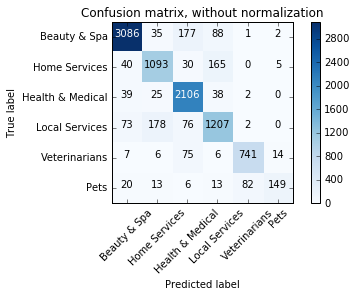

In [40]:
plot_confusion_matrix(cnf_matrix, classes=["Beauty & Spa", "Home Services", "Health & Medical", "Local Services", "Veterinarians", "Pets"], title='Confusion matrix, without normalization')

In [ ]:
def benchmark(X_train, y_train, X_test, y_test, name):
    # print("parameters:", params)
    t0 = time()
    clf = classify_train("logreg", X_train, df_train.Category)
    print("done in %fs" % (time() - t0))

    if hasattr(clf, 'coef_'):
        print("Percentage of non zeros coef: %f"
              % (np.mean(clf.coef_ != 0) * 100))
    print("Predicting the outcomes of the testing set")
    t0 = time()
    pred = clf.predict(X_test) #predictions
    print("done in %fs" % (time() - t0))

    print("Classification report on test set for classifier:")
    print(clf)
    print()
    print(classification_report(y_test, pred,
                               # target_names=news_test.target_names
                                ))

    cm = confusion_matrix(y_test, pred)
    print("Confusion matrix:")
    print(cm)

    # Show confusion matrix
    plt.matshow(cm)
    plt.title('Confusion matrix of the %s classifier' % name)
    plt.colorbar()


print("Testbenching a logreg classifier...")
df_train, df_test = read_data("train")
X_train,X_test = feature_extraction(df_train,df_test)
benchmark(X_train, df_train.Category, X_test, df_test.Category, 'Logreg')


plt.show()

Testbenching a logreg classifier...
